# Overview
- This follows the works, [Display-European-Art](https://www.kaggle.com/code/krsnewwave/display-european-art) and [Model-European-Art](https://www.kaggle.com/code/krsnewwave/model-european-art).
- In the latter, I decide on ResNet 18.
- **In this notebook, we will train a MultiLabel network with a pretrained resnet-18 and resnet-34.**
    - We train with all the parameters unfrozen.
- We will then visualize using the ff excellent [Github repo](https://github.com/utkuozbulak/pytorch-cnn-visualizations).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt

from tqdm import tqdm

import PIL.Image

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
from torch.autograd import Variable

import torchvision
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torchvision import datasets, models, transforms

import pytorch_lightning as pl

import skimage
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

torch.manual_seed(42)

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 100)

In [2]:
# unzip files
!mkdir artwork
!unzip -q /kaggle/input/display-european-art/selected_art.zip

In [3]:
DATASET_DIR = "artwork"
df_base = pd.read_csv(f"/kaggle/input/display-european-art/info-artwork.csv")
df_base[:2]

ID         artist                           title  \
0  1034  ANGELICO, Fra             madonna of the star   
1  1035  ANGELICO, Fra  scenes from the life of christ   

                                                                   picture data  \
0  c. 1424, tempera and gold on panel, 84 x 51 cm, museo di san marco, florence   
1         1451-52, tempera on panel, 123 x 160 cm, museo di san marco, florence   

                       file info  \
0   803*1400, true color, 191 kb   
1  1400*1071, true color, 322 kb   

                                             jpg url       born-died  \
0  https://www.wga.hu/art/a/angelico/12/00_madon.jpg  (c. 1400-1455)   
1  https://www.wga.hu/art/a/angelico/11/3armadio.jpg  (c. 1400-1455)   

              period   school                                            url  \
0  Early Renaissance  painter  https://www.wga.hu/html/a/angelico/index.html   
1  Early Renaissance  painter  https://www.wga.hu/html/a/angelico/index.html   

       base nationality  
0  Florence     Italian  
1  Florence     Italian

In [4]:
!ls /kaggle/input/model-european-art/

__notebook__.ipynb  artwork	       pytorch-cnn-visualizations
__output__.json     custom.css	       resnet18-europe-art.pth
__results__.html    logs	       resnet34-europe-art.pth
__results___files   model_results.csv  resnet50-europe-art.pth


# DataLoader
- square pad: https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850/5
- Multilabel version -- return period and artist

In [5]:
df_base.groupby(["period"])["artist"].value_counts()

period                artist                        
Baroque               REMBRANDT Harmenszoon van Rijn    539
                      CARAVAGGIO                        185
Early Renaissance     ANGELICO, Fra                     244
                      BOTTICELLI, Sandro                204
Impressionism         GOGH, Vincent van                 420
                      MONET, Claude                     198
Medieval              GIOTTO di Bondone                 551
                      DUCCIO di Buoninsegna             170
Northern Renaissance  BRUEGEL, Pieter the Elder         223
                      BOSCH, Hieronymus                 162
Romanticism           GOYA Y LUCIENTES, Francisco de    197
                      DELACROIX, Eugène                 105
Name: artist, dtype: int64

In [6]:
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')
    
class ArtPeriodDataSetMultiLabel(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe.copy()
        self.img_dir = img_dir
        # eliminate non-existing files
        print("Eliminate non-existing files")
        for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
            path = f'{img_dir}/{row["ID"]}.jpg'
            if not os.path.exists(path):
                self.dataframe.drop(idx, inplace=True)
                print("Dropping", path)
        
        # encode periods
        self.period_label_encoder = LabelEncoder()
        labels_encoded = self.period_label_encoder.fit_transform(self.dataframe["period"])
        self.dataframe["period_encoded"] = labels_encoded
        self.period_classes = self.period_label_encoder.classes_
        
        # encode artists
        self.artist_label_encoder = LabelEncoder()
        labels_encoded = self.artist_label_encoder.fit_transform(self.dataframe["artist"])
        self.dataframe["artist_encoded"] = labels_encoded
        self.artist_classes = self.artist_label_encoder.classes_
        
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):        
        img_path = f'{self.img_dir}/{self.dataframe.iloc[idx]["ID"]}.jpg'
        image = PIL.Image.open(img_path).convert('RGB')
        period_label = self.dataframe.iloc[idx]["period_encoded"]
        artist_label = self.dataframe.iloc[idx]["artist_encoded"]
        
        if self.transform:
            image = self.transform(image)
        return {"image" : image, "period_label" : period_label, "artist_label" : artist_label}

In [7]:
evaluation_split_compose = transforms.Compose([
        SquarePad(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
data_transforms = {
    'train': transforms.Compose([
        SquarePad(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=.5, contrast=.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': evaluation_split_compose,
    'test': evaluation_split_compose,
}

# Train, Test, Validation Splitting
- Last 30 are test
- Next to the last 30 are validation
- Rest are training

In [8]:
label_col = "period"
id_col = "ID"

n_test = 30
n_val = 30

df_base_test = df_base.groupby(label_col).tail(n_test)
df_base_train = df_base[~df_base[id_col].isin(df_base_test[id_col])]

df_base_val = df_base_train.groupby(label_col).tail(n_val)
df_base_train = df_base_train[~df_base_train[id_col].isin(df_base_val[id_col])]

# the remaining for training
df_base_train[label_col].value_counts().to_frame("train").join(
    df_base_val[label_col].value_counts().to_frame("val")).join(
    df_base_test[label_col].value_counts().to_frame("test")).join(
    df_base[label_col].value_counts().to_frame("total"))

train  val  test  total
Baroque                 664   30    30    724
Medieval                661   30    30    721
Impressionism           558   30    30    618
Early Renaissance       388   30    30    448
Northern Renaissance    325   30    30    385
Romanticism             242   30    30    302

In [9]:
splits = ["train", "val", "test"]
datasets = {x : ArtPeriodDataSetMultiLabel(df_split, DATASET_DIR , transform = data_transforms[x]) 
                for x, df_split in zip(
                    splits,
                    [df_base_train, df_base_val, df_base_test]
                )
           }

dataset_sizes = {x: len(datasets[x]) for x in splits}
print("Dataset sizes", dataset_sizes)
period_classes = datasets['train'].period_classes
artist_classes = datasets['train'].artist_classes
n_periods = len(period_classes)
n_artists = len(artist_classes)

print("Period Classes", period_classes)
print("Artist Classes", artist_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Eliminate non-existing files


100%|██████████| 2838/2838 [00:00<00:00, 20220.11it/s]


Eliminate non-existing files


100%|██████████| 180/180 [00:00<00:00, 13420.58it/s]


Eliminate non-existing files


100%|██████████| 180/180 [00:00<00:00, 14938.46it/s]

Dataset sizes {'train': 2838, 'val': 180, 'test': 180}
Period Classes ['Baroque' 'Early Renaissance' 'Impressionism' 'Medieval'
 'Northern Renaissance' 'Romanticism']
Artist Classes ['ANGELICO, Fra' 'BOSCH, Hieronymus' 'BOTTICELLI, Sandro'
 'BRUEGEL, Pieter the Elder' 'CARAVAGGIO' 'DELACROIX, Eugène'
 'DUCCIO di Buoninsegna' 'GIOTTO di Bondone' 'GOGH, Vincent van'
 'GOYA Y LUCIENTES, Francisco de' 'MONET, Claude'
 'REMBRANDT Harmenszoon van Rijn']


# Experiments

In [10]:
# following https://towardsdatascience.com/multilabel-classification-with-pytorch-in-5-minutes-a4fa8993cbc7
class LightningResNetMultiLabel(pl.LightningModule):
    def __init__(self, net, n_period, n_artists, criterion = F.cross_entropy, optimizer = None, scheduler = None, dropout_p = 0., lr=0.001, freeze_net=False):
        super().__init__()
        self.net = net
        
        self.feature_extractor = nn.Sequential(*(list(self.net.children())[:-1]))
        
        if freeze_net:
            for param in self.net.parameters():
                param.requires_grad = False

        num_ftrs = net.fc.in_features
        
        self.period_fc = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(in_features=num_ftrs, out_features=n_period)
        )
        self.artist_fc = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(in_features=num_ftrs, out_features=n_artists)
        )
        
        self.loss_func = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.learning_rate = lr
        
    def criterion(self, loss_func, outputs, inputs):
        losses = 0
        for i, key in enumerate(outputs):
            losses += loss_func(outputs[key], inputs[f'{key}_label'])
        
        return losses

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)

        return {
            'period': self.period_fc(x),
            'artist': self.artist_fc(x),
        }
    
#         return {"image" : image, "period_label" : period_label, "artist_label" : artist_label}
    @torch.no_grad()
    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))
        
    def _shared_eval_step(self, batch, batch_idx):
        images = batch["image"]
        period_labels = batch["period_label"]
        artist_labels = batch["artist_label"]
        
        out = self(images)
        out_period = out["period"]
        out_artist = out["artist"]
        
        loss = self.criterion(self.loss_func, out, batch)
        period_accu = self.accuracy(out_period, period_labels)
        artist_accu = self.accuracy(out_artist, artist_labels)
        return loss, period_accu, artist_accu
    
    def training_step(self, batch, batch_idx):
        loss, period_accu, artist_accu = self._shared_eval_step(batch, batch_idx)
        
        metrics = {'train_loss': loss, 'train_period_accuracy': period_accu, 'train_artist_accuracy': artist_accu}
        self.log_dict(metrics)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        with torch.no_grad():
            loss, period_accu, artist_accu = self._shared_eval_step(batch, batch_idx)
            metrics = {"test_loss": loss, 'test_period_accuracy': period_accu, 'test_artist_accuracy': artist_accu}
            self.log_dict(metrics)
            return metrics
    
    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            loss, period_accu, artist_accu = self._shared_eval_step(batch, batch_idx)
            metrics = {"val_loss": loss, 'val_period_accuracy': period_accu, 'val_artist_accuracy': artist_accu}
            self.log_dict(metrics, prog_bar=True)
            return metrics
        
    def configure_optimizers(self):
        if not self.optimizer:
            optimizer = optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)
            plateau_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose=True)
            return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": plateau_scheduler,
                "monitor": "val_accuracy"
                }
            }
        else:
            return {
                "optimizer" : self.optimizer,
                "lr_scheduler": {
                    "scheduler": self.scheduler,
                    "monitor": "val_loss"
                    }
            }

# Compare ResNets

In [11]:
max_epochs = 50
patience=10
plateau_lr_decrease=3
lr = 1e-3
momentum = 0.9

batch_size = 128
num_workers = 4

In [12]:
# 18
dataloaders = {
                "train" : torch.utils.data.DataLoader(datasets["train"], batch_size=batch_size, shuffle=True, num_workers=num_workers),
                "val" : torch.utils.data.DataLoader(datasets["val"], batch_size=batch_size, shuffle=False, num_workers=num_workers),
              }

net = models.resnet18(pretrained=True)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
plateau_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=plateau_lr_decrease, verbose=True)
clf_resnet18 = LightningResNetMultiLabel(net, n_periods, n_artists, optimizer = optimizer, scheduler=plateau_scheduler)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
callbacks = [pl.callbacks.EarlyStopping("val_loss", mode='min', patience=patience)]
logger = pl.loggers.CSVLogger("logs", name="resnet18-multilabel", version=0)

trainer_resnet18 = pl.Trainer(accelerator="auto", gpus=1 if torch.cuda.is_available() else 0, callbacks=callbacks, 
                              max_epochs=max_epochs, log_every_n_steps=1, logger=logger, auto_lr_find=True)
# tune learning rate
trainer_resnet18.tune(clf_resnet18, train_dataloaders=dataloaders['train'], val_dataloaders = dataloaders['val'])
print("New learning rate:", clf_resnet18.learning_rate)
trainer_resnet18.fit(model=clf_resnet18, train_dataloaders=dataloaders['train'], val_dataloaders = dataloaders['val'])
torch.save(clf_resnet18.state_dict(), "resnet18-multilabel-europe-art.pth")

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

New learning rate: 0.036307805477010104


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch     7: reducing learning rate of group 0 to 1.2023e-01.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    14: reducing learning rate of group 0 to 1.2023e-02.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    18: reducing learning rate of group 0 to 1.2023e-03.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [14]:
# 34
dataloaders = {
                "train" : torch.utils.data.DataLoader(datasets["train"], batch_size=batch_size, shuffle=True, num_workers=num_workers),
                "val" : torch.utils.data.DataLoader(datasets["val"], batch_size=batch_size, shuffle=False, num_workers=num_workers),
              }

net = models.resnet34(pretrained=True)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
plateau_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=plateau_lr_decrease, verbose=True)
clf_resnet34 = LightningResNetMultiLabel(net, n_periods, n_artists, optimizer = optimizer, scheduler=plateau_scheduler)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [15]:
callbacks = [pl.callbacks.EarlyStopping("val_loss", mode='min', patience=patience)]
logger = pl.loggers.CSVLogger("logs", name="resnet34-multilabel", version=0)

trainer_resnet34 = pl.Trainer(accelerator="auto", gpus=1 if torch.cuda.is_available() else 0, callbacks=callbacks, 
                              max_epochs=max_epochs, log_every_n_steps=1, logger=logger, auto_lr_find=True)
# tune lr
trainer_resnet34.tune(clf_resnet34, train_dataloaders=dataloaders['train'], val_dataloaders = dataloaders['val'])
print("New learning rate:", clf_resnet34.learning_rate)
trainer_resnet34.fit(model=clf_resnet34, train_dataloaders=dataloaders['train'], val_dataloaders = dataloaders['val'])
torch.save(clf_resnet18.state_dict(), "resnet34-multilabel-europe-art.pth")

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

New learning rate: 0.030199517204020192


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch     7: reducing learning rate of group 0 to 1.2023e-01.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    12: reducing learning rate of group 0 to 1.2023e-02.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    16: reducing learning rate of group 0 to 1.2023e-03.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Evaluation on Test

In [16]:
import math
# utility code to show errors
def display_gallery_of_errors(df: pd.DataFrame, title, img_dir, figsize=(15, 30)):
    grid_rows = 6
    grid_cols = math.ceil(len(df) / grid_rows)
    
    fig = plt.figure(figsize=(figsize))
    for i, (_, row) in enumerate(df.iterrows(), 1):
        img_path = f'{img_dir}/{row["ID"]}.jpg'
        img = PIL.Image.open(img_path).convert('RGB')
        img_padded = SquarePad()(img)
        img_resized = transforms.Resize((224,224))(img_padded)
        
        ax = fig.add_subplot(grid_cols, grid_rows, i)
        ax.imshow(img_resized)
        ax.axis('off')
        error_title = f'ID: {row["ID"]} \nT: {row["period"]} \nP: {row["predictions"]}'
        ax.set_title(error_title)
        
    fig.suptitle(title, y=1., fontsize=16)
    fig.tight_layout()
    

def get_probs_preds_labels(net, test_loader, device):

    list_predicted_period = []
    list_predicted_artist = []
    list_period_labels = []
    list_artist_labels = []
    with torch.no_grad():
        for batch in tqdm(test_loader):           

            images = batch["image"].to(device)
            period_labels = batch["period_label"].to(device)
            artist_labels = batch["artist_label"].to(device)
            
            out = net(images)
            out_period = out["period"]
            out_artist = out["artist"]
            
            # period
            _, predicted_period = torch.max(out_period.data, 1)
            # artist
            _, predicted_artist = torch.max(out_artist.data, 1)
            list_predicted_period.extend(predicted_period.cpu().numpy())
            list_predicted_artist.extend(predicted_artist.cpu().numpy())
            list_period_labels.extend(period_labels.cpu().numpy())
            list_artist_labels.extend(artist_labels.cpu().numpy())
            
    return list_predicted_period, list_predicted_artist, list_period_labels, list_artist_labels

def display_errors(df_base, list_preds, list_labels, classes):
    bool_index = np.array(list_preds) != np.array(list_labels)
    # populate test df copy with predictions
    df_base_test_copy = df_base[bool_index].copy()
    # get predictions
    predictions = [classes[v] for v in np.array(list_preds)[bool_index]]
    df_base_test_copy["predictions"] = predictions
    # sort values
    df_base_test_copy = df_base_test_copy.sort_values(by="period")

    display_gallery_of_errors(df_base_test_copy, "ResNet-18 Errors", DATASET_DIR, figsize=(20, 40))

In [17]:
model_names = ["resnet18-multilabel", "resnet34-multilabel"]
list_df = []

for name in model_names:
    log_file = f'logs/{name}/version_0/metrics.csv'
    df_resnet_history = pd.read_csv(log_file)

    df_resnet_history = df_resnet_history.fillna(method='ffill')
    # get only last epochs
    df_resnet_history = df_resnet_history.groupby("epoch").tail(1)
    df_resnet_history["model"] = name
    list_df.append(df_resnet_history)
    
# combine
df_histories = pd.concat(list_df)
df_histories.to_csv("model_results.csv", index=False)
df_histories

train_loss  train_period_accuracy  train_artist_accuracy  epoch  step  \
23     4.128757               0.363636               0.090909      0    22   
47     3.544230               0.454545               0.545455      1    45   
71     3.609853               0.363636               0.272727      2    68   
95     3.263979               0.409091               0.272727      3    91   
119    3.601743               0.318182               0.272727      4   114   
143    3.703835               0.500000               0.363636      5   137   
167    3.242414               0.500000               0.409091      6   160   
191    2.910988               0.590909               0.409091      7   183   
215    2.577962               0.590909               0.454545      8   206   
239    2.958278               0.545455               0.363636      9   229   
263    2.837975               0.545455               0.454545     10   252   
287    2.984094               0.409091               0.363636     11   275   
311    3.201190               0.545455               0.363636     12   298   
335    3.434757               0.363636               0.272727     13   321   
359    2.745605               0.681818               0.590909     14   344   
383    2.800276               0.545455               0.500000     15   367   
407    2.388676               0.681818               0.500000     16   390   
431    3.411081               0.363636               0.363636     17   413   
455    2.465366               0.727273               0.409091     18   436   
479    2.721757               0.590909               0.454545     19   459   
23     4.077559               0.272727               0.181818      0    22   
47     4.364818               0.227273               0.181818      1    45   
71     3.168586               0.454545               0.363636      2    68   
95     3.655209               0.500000               0.318182      3    91   
119    3.603471               0.409091               0.181818      4   114   
143    3.693718               0.363636               0.318182      5   137   
167    3.415359               0.363636               0.409091      6   160   
191    2.771143               0.636364               0.363636      7   183   
215    2.744265               0.636364               0.500000      8   206   
239    3.331872               0.500000               0.227273      9   229   
263    3.448797               0.318182               0.227273     10   252   
287    3.619359               0.409091               0.363636     11   275   
311    3.169301               0.590909               0.454545     12   298   
335    3.708995               0.318182               0.272727     13   321   
359    3.228766               0.363636               0.272727     14   344   
383    3.455198               0.545455               0.409091     15   367   
407    3.392340               0.545455               0.363636     16   390   
431    3.156365               0.636364               0.363636     17   413   

       val_loss  val_period_accuracy  val_artist_accuracy                model  
23    72.251129             0.127778             0.000000  resnet18-multilabel  
47     5.686039             0.311111             0.000000  resnet18-multilabel  
71     4.728202             0.438889             0.005556  resnet18-multilabel  
95     4.918058             0.411111             0.005556  resnet18-multilabel  
119    4.872024             0.466667             0.005556  resnet18-multilabel  
143    4.887824             0.461111             0.016667  resnet18-multilabel  
167    5.035295             0.350000             0.022222  resnet18-multilabel  
191    4.665995             0.522222             0.022222  resnet18-multilabel  
215    4.614583             0.561111             0.027778  resnet18-multilabel  
239    4.559726             0.588889             0.044444  resnet18-multilabel  
263    4.615993             0.550000             0.038889  resnet18-mul

In [18]:
test_loader = torch.utils.data.DataLoader(datasets["test"], batch_size=batch_size, shuffle=False, num_workers=num_workers)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
print("Resnet18")
out = trainer_resnet18.test(dataloaders=test_loader)
print("Resnet34")
out = trainer_resnet34.test(dataloaders=test_loader)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1399: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."


Resnet18


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_artist_accuracy': 0.0555555559694767,
 'test_loss': 4.947425842285156,
 'test_period_accuracy': 0.5666666626930237}
--------------------------------------------------------------------------------
Resnet34


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_artist_accuracy': 0.0,
 'test_loss': 4.867283344268799,
 'test_period_accuracy': 0.4722222089767456}
--------------------------------------------------------------------------------


## ResNet 18

In [20]:
list_predicted_period, list_predicted_artist, list_period_labels, list_artist_labels = get_probs_preds_labels(clf_resnet18.to(device), test_loader, device)


100%|██████████| 2/2 [00:05<00:00,  2.70s/it]


In [21]:
print("Period stats")
display(pd.DataFrame(confusion_matrix(list_period_labels, list_predicted_period, labels=range(n_periods)), columns="Predicted-" + period_classes, index="Actual-" + period_classes))
display(pd.DataFrame(classification_report(list_period_labels, list_predicted_period, output_dict=True, target_names=period_classes)).T.round(2))

print("Artist stats")
display(pd.DataFrame(confusion_matrix(list_artist_labels, list_predicted_artist, labels=range(n_artists)), columns="Predicted-" + artist_classes, index="Actual-" + artist_classes))
display(pd.DataFrame(classification_report(list_artist_labels, list_predicted_artist, output_dict=True, target_names=artist_classes, labels=range(n_artists))).T.round(2))

Period stats


Predicted-Baroque  Predicted-Early Renaissance  \
Actual-Baroque                              16                            2   
Actual-Early Renaissance                     9                            2   
Actual-Impressionism                         7                            0   
Actual-Medieval                              0                            0   
Actual-Northern Renaissance                  8                            2   
Actual-Romanticism                          23                            1   

                             Predicted-Impressionism  Predicted-Medieval  \
Actual-Baroque                                     1                   9   
Actual-Early Renaissance                           6                   8   
Actual-Impressionism                              18                   5   
Actual-Medieval                                    6                  24   
Actual-Northern Renaissance                        4                   4   
Actual-Romanticism                                 3                   2   

                             Predicted-Northern Renaissance  \
Actual-Baroque                                            2   
Actual-Early Renaissance                                  4   
Actual-Impressionism                                      0   
Actual-Medieval                                           0   
Actual-Northern Renaissance                              12   
Actual-Romanticism                                        0   

                             Predicted-Romanticism  
Actual-Baroque                                   0  
Actual-Early Renaissance                         1  
Actual-Impressionism                             0  
Actual-Medieval                                  0  
Actual-Northern Renaissance                      0  
Actual-Romanticism                               1

precision  recall  f1-score  support
Baroque                    0.25    0.53      0.34    30.00
Early Renaissance          0.29    0.07      0.11    30.00
Impressionism              0.47    0.60      0.53    30.00
Medieval                   0.46    0.80      0.59    30.00
Northern Renaissance       0.67    0.40      0.50    30.00
Romanticism                0.50    0.03      0.06    30.00
accuracy                   0.41    0.41      0.41     0.41
macro avg                  0.44    0.41      0.35   180.00
weighted avg               0.44    0.41      0.35   180.00

Artist stats


Predicted-ANGELICO, Fra  \
Actual-ANGELICO, Fra                                         2   
Actual-BOSCH, Hieronymus                                     2   
Actual-BOTTICELLI, Sandro                                    2   
Actual-BRUEGEL, Pieter the Elder                             1   
Actual-CARAVAGGIO                                            1   
Actual-DELACROIX, Eugène                                     0   
Actual-DUCCIO di Buoninsegna                                 0   
Actual-GIOTTO di Bondone                                     0   
Actual-GOGH, Vincent van                                     0   
Actual-GOYA Y LUCIENTES, Francisco de                        0   
Actual-MONET, Claude                                         0   
Actual-REMBRANDT Harmenszoon van Rijn                        0   

                                       Predicted-BOSCH, Hieronymus  \
Actual-ANGELICO, Fra                                             1   
Actual-BOSCH, Hieronymus                                         3   
Actual-BOTTICELLI, Sandro                                        0   
Actual-BRUEGEL, Pieter the Elder                                 0   
Actual-CARAVAGGIO                                                0   
Actual-DELACROIX, Eugène                                         0   
Actual-DUCCIO di Buoninsegna                                     0   
Actual-GIOTTO di Bondone                                         0   
Actual-GOGH, Vincent van                                         0   
Actual-GOYA Y LUCIENTES, Francisco de                            0   
Actual-MONET, Claude                                             0   
Actual-REMBRANDT Harmenszoon van Rijn                            0   

                                       Predicted-BOTTICELLI, Sandro  \
Actual-ANGELICO, Fra                                              0   
Actual-BOSCH, Hieronymus                                          0   
Actual-BOTTICELLI, Sandro                                         0   
Actual-BRUEGEL, Pieter the Elder                                  0   
Actual-CARAVAGGIO                                                 0   
Actual-DELACROIX, Eugène                                          3   
Actual-DUCCIO di Buoninsegna                                      0   
Actual-GIOTTO di Bondone                                          0   
Actual-GOGH, Vincent van                                          0   
Actual-GOYA Y LUCIENTES, Francisco de                             0   
Actual-MONET, Claude                                              0   
Actual-REMBRANDT Harmenszoon van Rijn                             0   

                                       Predicted-BRUEGEL, Pieter the Elder  \
Actual-ANGELICO, Fra                                                     1   
Actual-BOSCH, Hieronymus                                                 8   
Actual-BOTTICELLI, Sandro                                                0   
Actual-BRUEGEL, Pieter the Elder                                         0   
Actual-CARAVAGGIO                                                        0   
Actual-DELACROIX, Eugène                                                 2   
Actual-DUCCIO di Buoninsegna                                             0   
Actual-GIOTTO di Bondone                                                 0   
Actual-GOGH, Vincent van                                                 0   
Actual-GOYA Y LUCIENTES, Francisco de                                    0   
Actual-MONET, Claude                                                     0   
Actual-REMBRANDT Harmenszoon van Rijn                                    0   

                                       Predicted-CARAVAGGIO  \
Actual-ANGELICO, Fra                                      2   
Actual-BOSCH, Hieronymus                                  1   
Actual-BOTTICELLI, Sandro                                 0   
Actual-BRUEGEL, Pieter the Elder                          8   
Actual-CARAVAGG

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

precision  recall  f1-score  support
ANGELICO, Fra                        0.25    0.07      0.11     30.0
BOSCH, Hieronymus                    0.75    0.10      0.18     30.0
BOTTICELLI, Sandro                   0.00    0.00      0.00     30.0
BRUEGEL, Pieter the Elder            0.00    0.00      0.00     30.0
CARAVAGGIO                           0.00    0.00      0.00     30.0
DELACROIX, Eugène                    0.00    0.00      0.00     30.0
DUCCIO di Buoninsegna                0.00    0.00      0.00      0.0
GIOTTO di Bondone                    0.00    0.00      0.00      0.0
GOGH, Vincent van                    0.00    0.00      0.00      0.0
GOYA Y LUCIENTES, Francisco de       0.00    0.00      0.00      0.0
MONET, Claude                        0.00    0.00      0.00      0.0
REMBRANDT Harmenszoon van Rijn       0.00    0.00      0.00      0.0
micro avg                            0.03    0.03      0.03    180.0
macro avg                            0.08    0.01      0.02    180.0
weighted avg                         0.17    0.03      0.05    180.0

Display period incorrects only


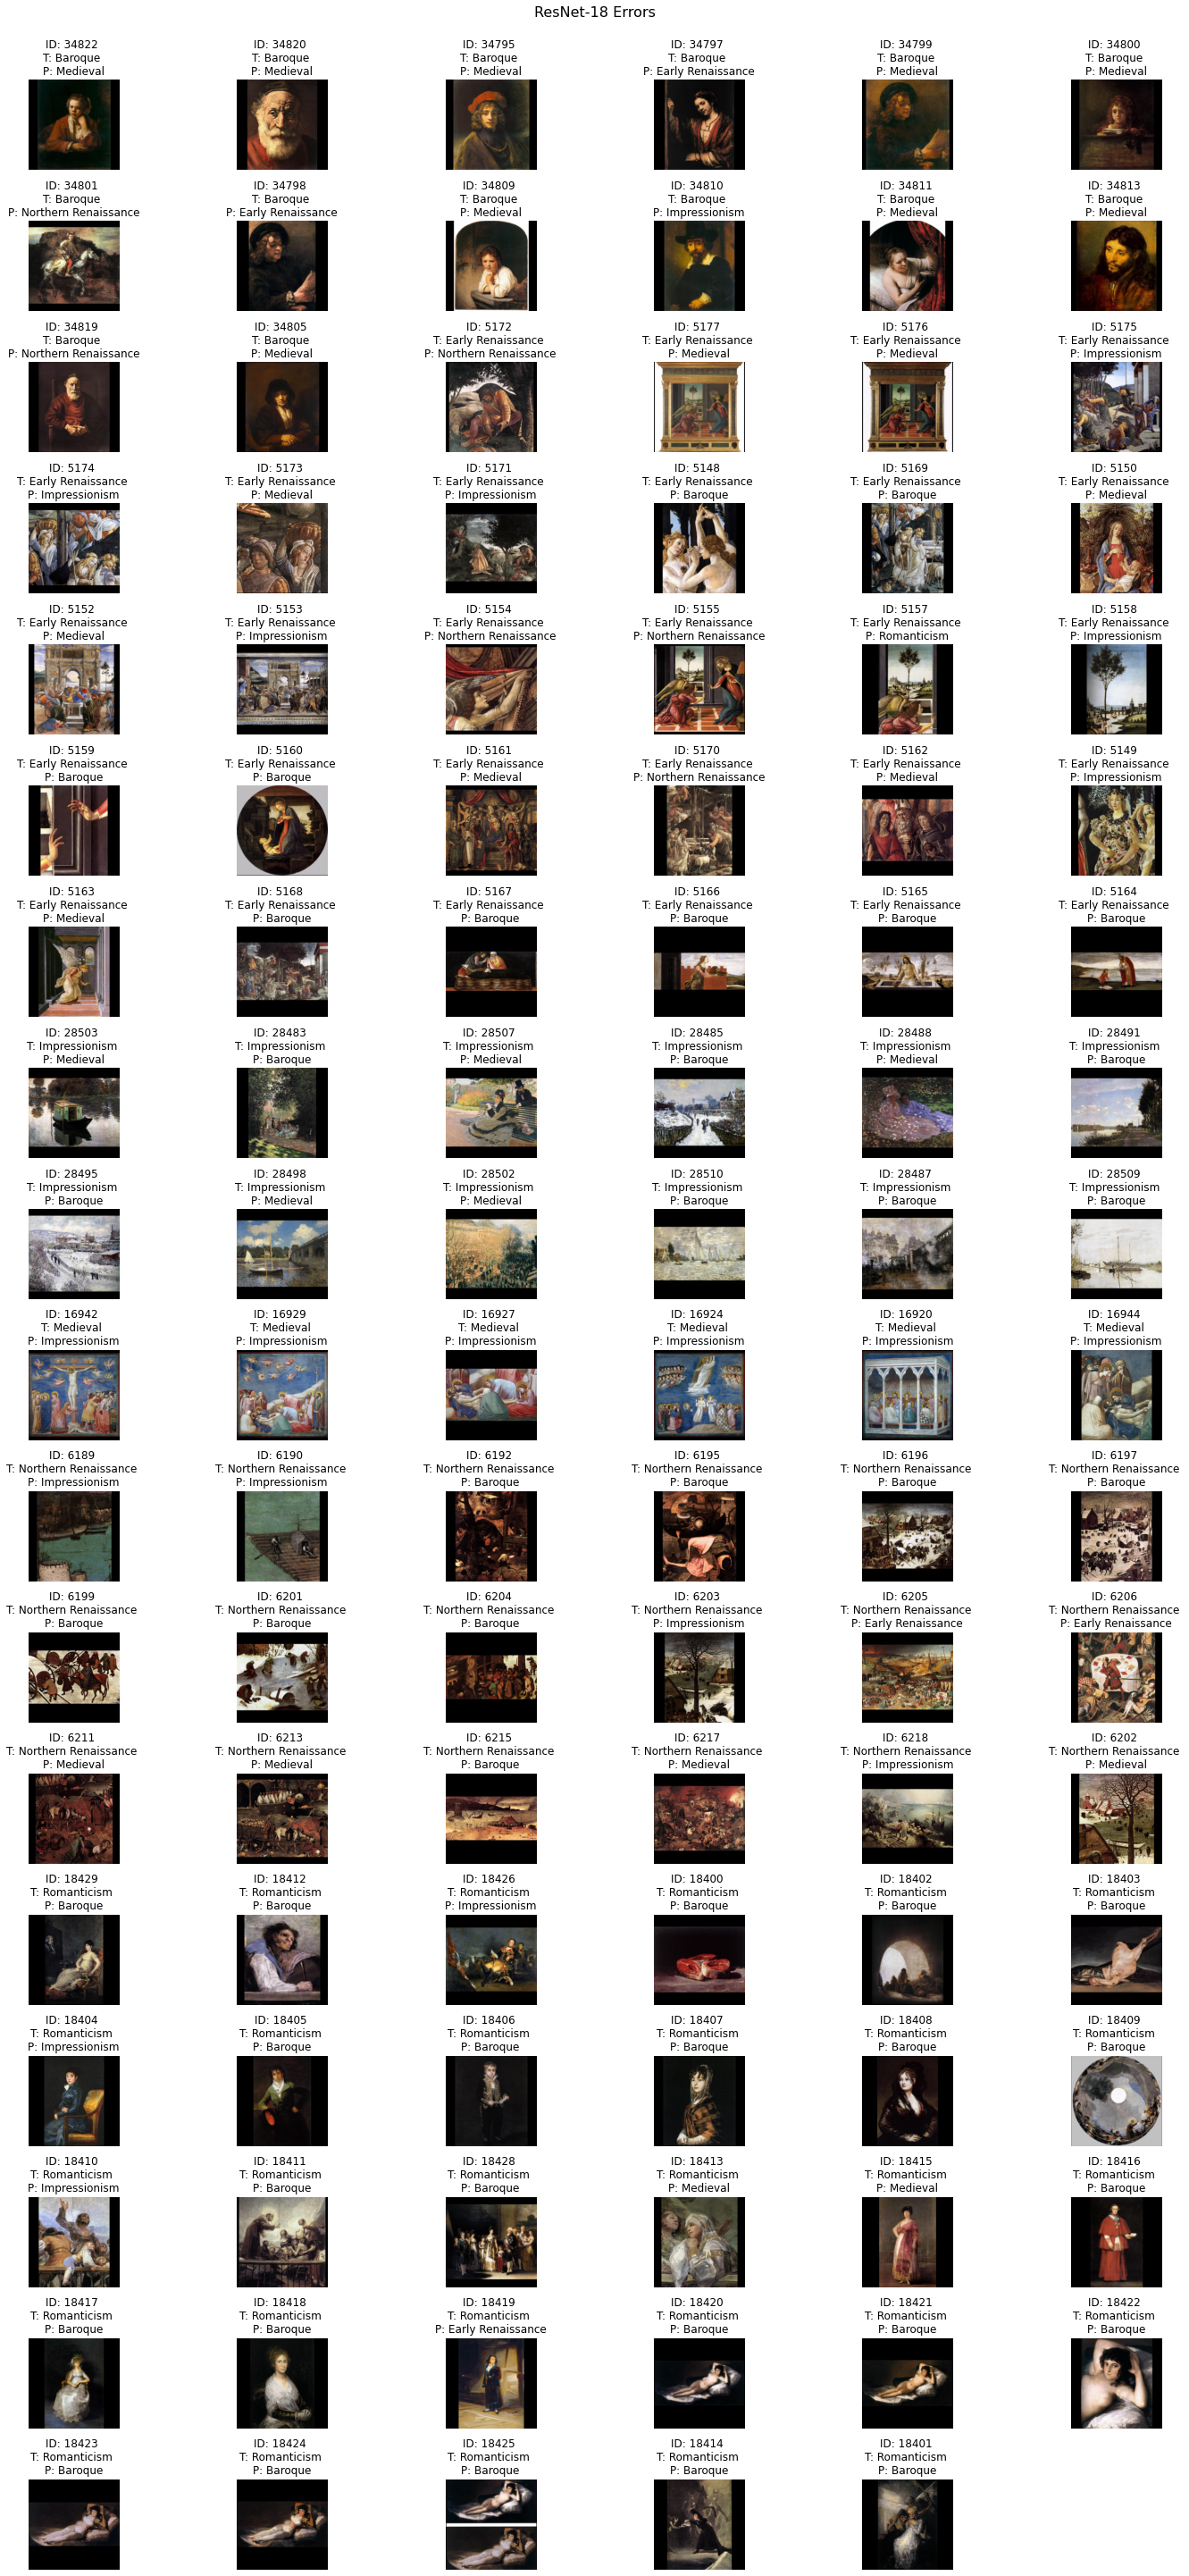

In [22]:
print("Display period incorrects only")
display_errors(df_base_test, list_predicted_period, list_period_labels, period_classes)

## ResNet 32

In [23]:
list_predicted_period, list_predicted_artist, list_period_labels, list_artist_labels = get_probs_preds_labels(clf_resnet34.to(device), test_loader, device)

  0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 2/2 [00:04<00:00,  2.45s/it]


In [24]:
print("Period stats")
display(pd.DataFrame(confusion_matrix(list_period_labels, list_predicted_period, labels=range(n_periods)), columns="Predicted-" + period_classes, index="Actual-" + period_classes))
display(pd.DataFrame(classification_report(list_period_labels, list_predicted_period, output_dict=True, target_names=period_classes)).T.round(2))

print("Artist stats")
display(pd.DataFrame(confusion_matrix(list_artist_labels, list_predicted_artist, labels=range(n_artists)), columns="Predicted-" + artist_classes, index="Actual-" + artist_classes))
display(pd.DataFrame(classification_report(list_artist_labels, list_predicted_artist, output_dict=True, target_names=artist_classes, labels=range(n_artists))).T.round(2))

Period stats


Predicted-Baroque  Predicted-Early Renaissance  \
Actual-Baroque                              16                            1   
Actual-Early Renaissance                     9                            0   
Actual-Impressionism                         9                            0   
Actual-Medieval                              0                            0   
Actual-Northern Renaissance                 15                            0   
Actual-Romanticism                          21                            0   

                             Predicted-Impressionism  Predicted-Medieval  \
Actual-Baroque                                     0                  13   
Actual-Early Renaissance                           8                   9   
Actual-Impressionism                              12                   9   
Actual-Medieval                                    8                  22   
Actual-Northern Renaissance                        3                   2   
Actual-Romanticism                                 8                   1   

                             Predicted-Northern Renaissance  \
Actual-Baroque                                            0   
Actual-Early Renaissance                                  4   
Actual-Impressionism                                      0   
Actual-Medieval                                           0   
Actual-Northern Renaissance                              10   
Actual-Romanticism                                        0   

                             Predicted-Romanticism  
Actual-Baroque                                   0  
Actual-Early Renaissance                         0  
Actual-Impressionism                             0  
Actual-Medieval                                  0  
Actual-Northern Renaissance                      0  
Actual-Romanticism                               0

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision  recall  f1-score  support
Baroque                    0.23    0.53      0.32    30.00
Early Renaissance          0.00    0.00      0.00    30.00
Impressionism              0.31    0.40      0.35    30.00
Medieval                   0.39    0.73      0.51    30.00
Northern Renaissance       0.71    0.33      0.45    30.00
Romanticism                0.00    0.00      0.00    30.00
accuracy                   0.33    0.33      0.33     0.33
macro avg                  0.27    0.33      0.27   180.00
weighted avg               0.27    0.33      0.27   180.00

Artist stats


Predicted-ANGELICO, Fra  \
Actual-ANGELICO, Fra                                         0   
Actual-BOSCH, Hieronymus                                     0   
Actual-BOTTICELLI, Sandro                                    0   
Actual-BRUEGEL, Pieter the Elder                             0   
Actual-CARAVAGGIO                                            0   
Actual-DELACROIX, Eugène                                     0   
Actual-DUCCIO di Buoninsegna                                 0   
Actual-GIOTTO di Bondone                                     0   
Actual-GOGH, Vincent van                                     0   
Actual-GOYA Y LUCIENTES, Francisco de                        0   
Actual-MONET, Claude                                         0   
Actual-REMBRANDT Harmenszoon van Rijn                        0   

                                       Predicted-BOSCH, Hieronymus  \
Actual-ANGELICO, Fra                                             1   
Actual-BOSCH, Hieronymus                                         0   
Actual-BOTTICELLI, Sandro                                        0   
Actual-BRUEGEL, Pieter the Elder                                 0   
Actual-CARAVAGGIO                                                0   
Actual-DELACROIX, Eugène                                         0   
Actual-DUCCIO di Buoninsegna                                     0   
Actual-GIOTTO di Bondone                                         0   
Actual-GOGH, Vincent van                                         0   
Actual-GOYA Y LUCIENTES, Francisco de                            0   
Actual-MONET, Claude                                             0   
Actual-REMBRANDT Harmenszoon van Rijn                            0   

                                       Predicted-BOTTICELLI, Sandro  \
Actual-ANGELICO, Fra                                              0   
Actual-BOSCH, Hieronymus                                          0   
Actual-BOTTICELLI, Sandro                                         0   
Actual-BRUEGEL, Pieter the Elder                                  0   
Actual-CARAVAGGIO                                                 0   
Actual-DELACROIX, Eugène                                          0   
Actual-DUCCIO di Buoninsegna                                      0   
Actual-GIOTTO di Bondone                                          0   
Actual-GOGH, Vincent van                                          0   
Actual-GOYA Y LUCIENTES, Francisco de                             0   
Actual-MONET, Claude                                              0   
Actual-REMBRANDT Harmenszoon van Rijn                             0   

                                       Predicted-BRUEGEL, Pieter the Elder  \
Actual-ANGELICO, Fra                                                     3   
Actual-BOSCH, Hieronymus                                                10   
Actual-BOTTICELLI, Sandro                                                0   
Actual-BRUEGEL, Pieter the Elder                                         0   
Actual-CARAVAGGIO                                                        0   
Actual-DELACROIX, Eugène                                                 0   
Actual-DUCCIO di Buoninsegna                                             0   
Actual-GIOTTO di Bondone                                                 0   
Actual-GOGH, Vincent van                                                 0   
Actual-GOYA Y LUCIENTES, Francisco de                                    0   
Actual-MONET, Claude                                                     0   
Actual-REMBRANDT Harmenszoon van Rijn                                    0   

                                       Predicted-CARAVAGGIO  \
Actual-ANGELICO, Fra                                      0   
Actual-BOSCH, Hieronymus                                  0   
Actual-BOTTICELLI, Sandro                                 0   
Actual-BRUEGEL, Pieter the Elder                          0   
Actual-CARAVAGG

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

precision  recall  f1-score  support
ANGELICO, Fra                         0.0     0.0       0.0     30.0
BOSCH, Hieronymus                     0.0     0.0       0.0     30.0
BOTTICELLI, Sandro                    0.0     0.0       0.0     30.0
BRUEGEL, Pieter the Elder             0.0     0.0       0.0     30.0
CARAVAGGIO                            0.0     0.0       0.0     30.0
DELACROIX, Eugène                     0.0     0.0       0.0     30.0
DUCCIO di Buoninsegna                 0.0     0.0       0.0      0.0
GIOTTO di Bondone                     0.0     0.0       0.0      0.0
GOGH, Vincent van                     0.0     0.0       0.0      0.0
GOYA Y LUCIENTES, Francisco de        0.0     0.0       0.0      0.0
MONET, Claude                         0.0     0.0       0.0      0.0
REMBRANDT Harmenszoon van Rijn        0.0     0.0       0.0      0.0
micro avg                             0.0     0.0       0.0    180.0
macro avg                             0.0     0.0       0.0    180.0
weighted avg                          0.0     0.0       0.0    180.0

Display period incorrects only


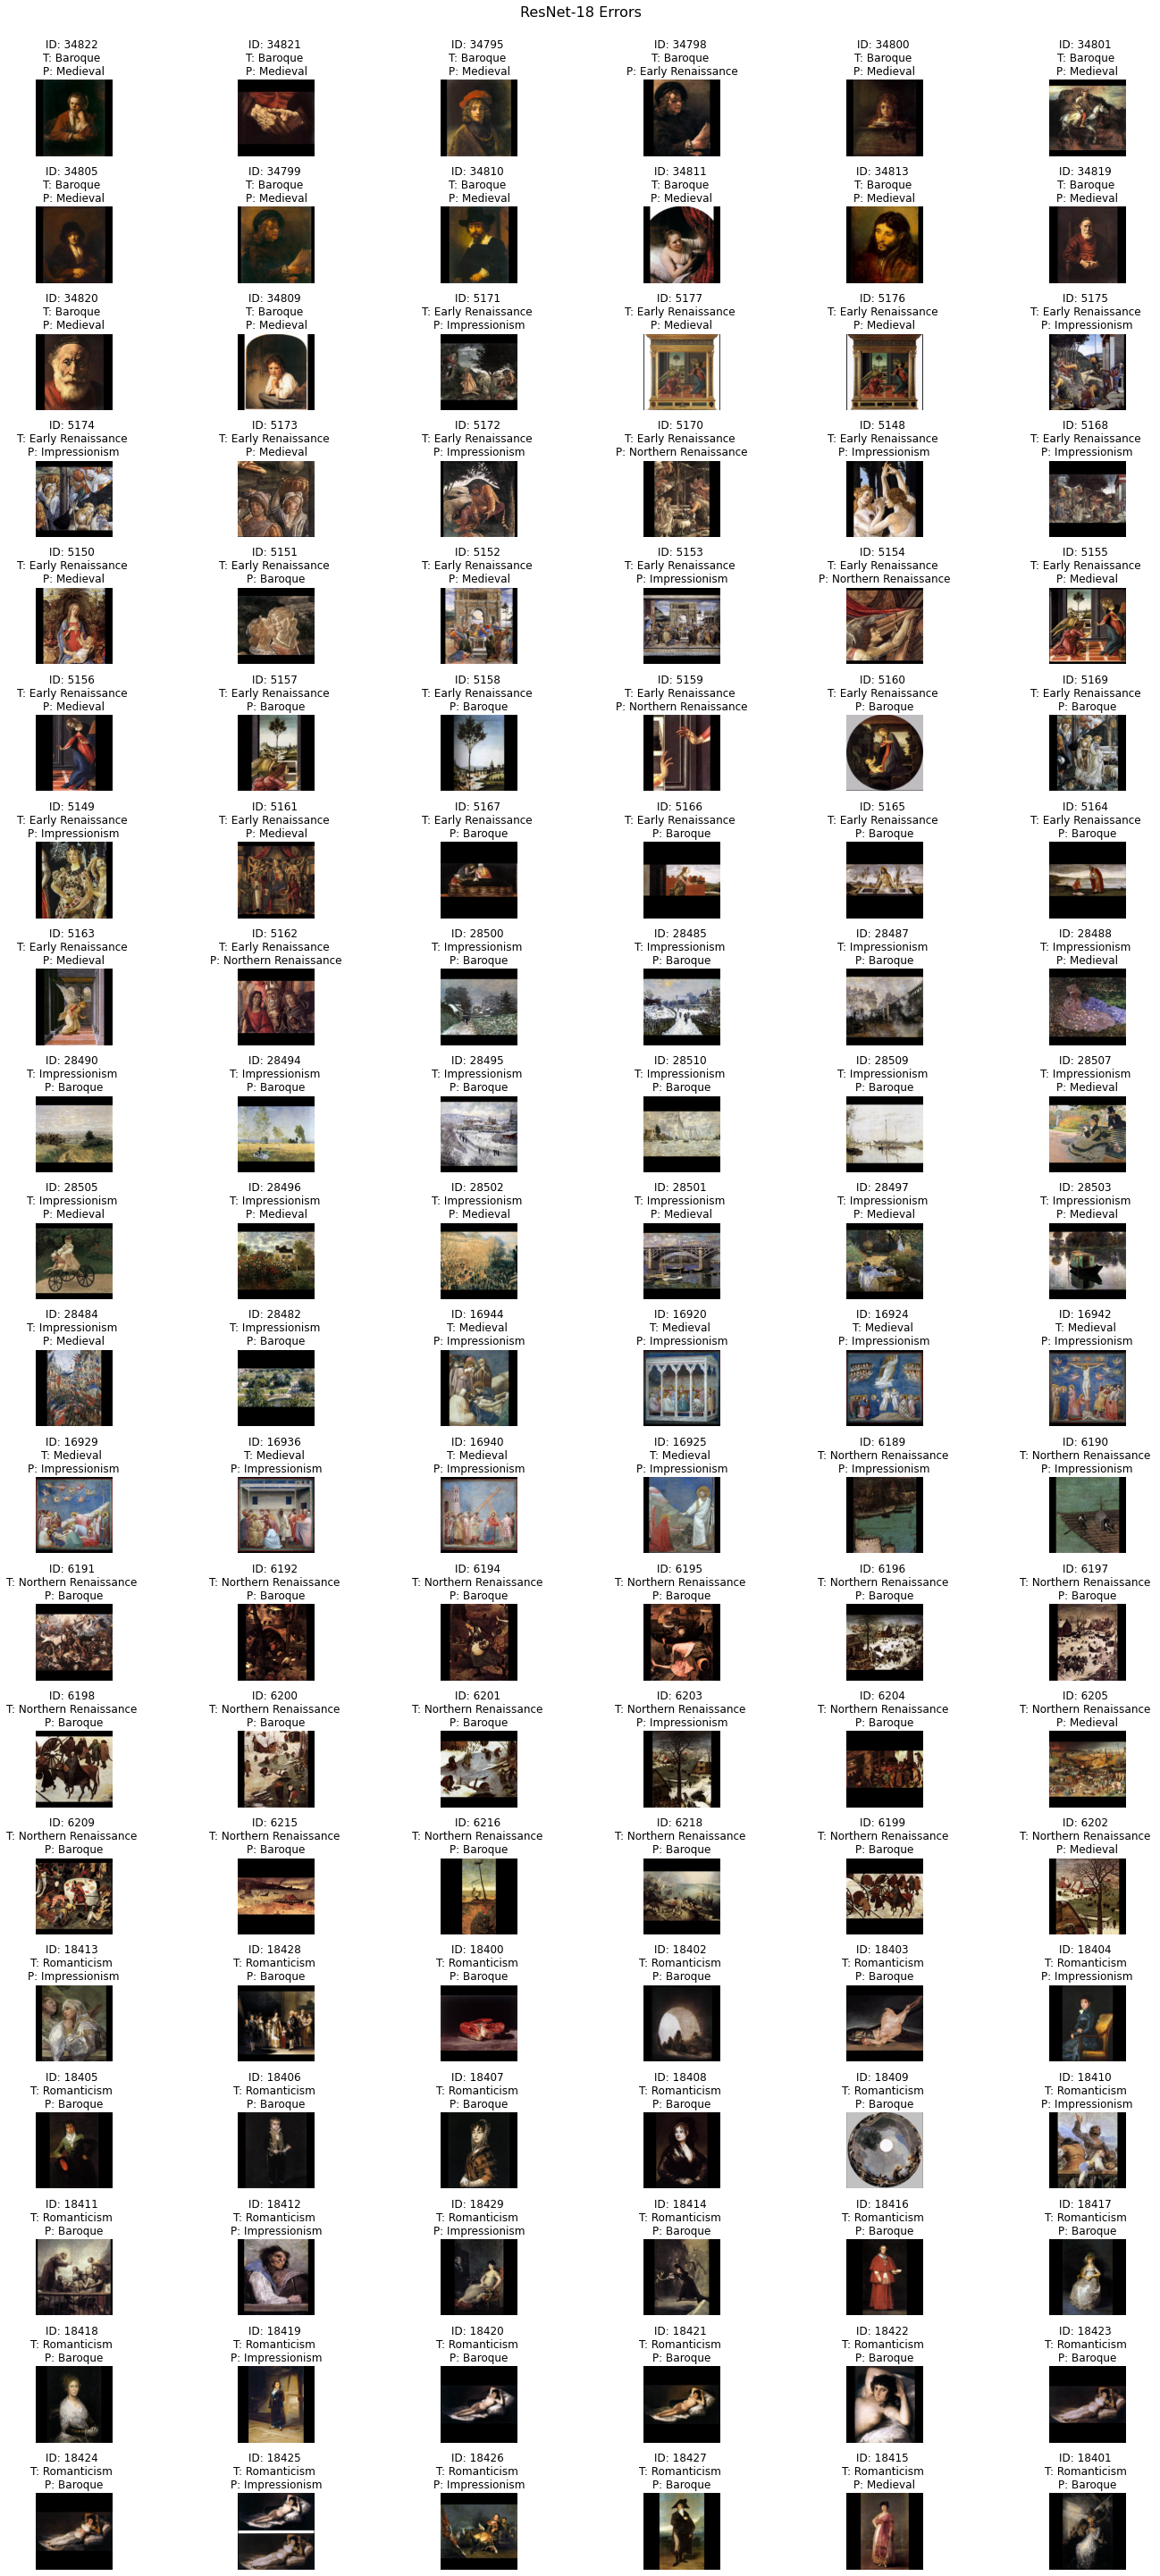

In [25]:
print("Display period incorrects only")
display_errors(df_base_test, list_predicted_period, list_period_labels, period_classes)